In [1]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# -----------------------------
# 2. Enhanced PointNet2D
# -----------------------------
class PointNet2D(nn.Module):
    def __init__(self, input_dim=2, emb_dim=256):
        super(PointNet2D, self).__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, emb_dim, kernel_size=1),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU()
        )

    def forward(self, x, mask=None):
        # x: (B, N, 2) -> (B, 2, N)
        x = x.transpose(1, 2)
        features = self.mlp(x)  # (B, emb_dim, N)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, N)
            features = features.masked_fill(mask == 0, -1e2)

        embedding = torch.max(features, dim=2)[0]  # (B, emb_dim)
        return embedding


In [3]:
# -----------------------------
# 3. LSTM Slice Encoder
# -----------------------------
class LSTMSliceEncoder(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=256, num_layers=4, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

    def forward(self, x):
        # x: (B, S, D)
        _, (h_n, _) = self.lstm(x)
        if self.lstm.bidirectional:
            return torch.cat((h_n[-2], h_n[-1]), dim=-1)  # (B, 2H)
        else:
            return h_n[-1]  # (B, H)

In [4]:
# -----------------------------
# 4. Cd Regressor MLP
# -----------------------------
class CdRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [5]:
# -----------------------------
# 5. Full Model Assembly
# -----------------------------
class CdPredictorNet(nn.Module):
    def __init__(self, pointnet, lstm_encoder, regressor):
        super().__init__()
        self.pointnet = pointnet
        self.lstm_encoder = lstm_encoder
        self.regressor = regressor

    def forward(self, slices, point_mask, slice_mask):
        B, S, N, D = slices.shape
        flat_slices = slices.view(B * S, N, D)
        flat_mask = point_mask.view(B * S, N)

        slice_embs = self.pointnet(flat_slices, flat_mask)  # (B*S, 256)
        slice_embs = slice_embs.view(B, S, -1)  # (B, 80, 256)

        car_emb = self.lstm_encoder(slice_embs)  # (B, 512 if bidirectional)
        return self.regressor(car_emb)

In [6]:
# -----------------------------
# 6. Dataset Loader
# -----------------------------
class CarSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, ids_txt, npz_dir, csv_path, max_cars=None):
        self.car_ids = [line.strip() for line in open(ids_txt)]
        if max_cars:
            self.car_ids = self.car_ids[:max_cars]
        self.npz_dir = npz_dir
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        car_id = self.car_ids[idx]
        data = np.load(os.path.join(self.npz_dir, f"{car_id}_axis-x.npz"))
        slices = torch.tensor(data["slices"], dtype=torch.float32)  # (80, 6500, 2)
        point_mask = torch.tensor(data["point_mask"], dtype=torch.float32)  # (80, 6500)
        slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32)  # (80,)
        cd_value = self.df[self.df["Design"] == car_id]["Average Cd"].values[0]
        return slices, point_mask, slice_mask, torch.tensor(cd_value, dtype=torch.float32)

In [7]:
import os
import glob
import torch
import torch.nn as nn
from tqdm import tqdm

def train_model(resume=True, num_epochs=50, max_cars=2000,
                checkpoint_dir="../outputs/checkpoints", early_stopping_patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model components
    pointnet = PointNet2D()
    lstm_encoder = LSTMSliceEncoder()
    regressor = CdRegressor(input_dim=512)
    model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.SmoothL1Loss()  # Replaced with more stable alternative to MSE

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    best_loss = float("inf")
    patience_counter = 0
    epoch_losses = []

    # Resume from checkpoint if exists
    if resume:
        checkpoints = sorted(glob.glob(f"{checkpoint_dir}/epoch_*_loss*.pt"))
        if checkpoints:
            latest_ckpt = checkpoints[-1]
            print(f"🔄 Resuming from checkpoint: {latest_ckpt}")
            state = torch.load(latest_ckpt, map_location=device)
            model.load_state_dict(state['model'])
            optimizer.load_state_dict(state['optimizer'])
            start_epoch = state['epoch'] + 1
            epoch_losses = state.get('epoch_losses', [])
            best_loss = min(epoch_losses) if epoch_losses else float("inf")
        else:
            print("⏩ No previous checkpoint found, starting fresh.")

    # Load dataset
    dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/train_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=max_cars
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True , pin_memory=True)

    try:
        for epoch in range(start_epoch, num_epochs + 1):
            model.train()
            total_loss = 0.0
            pbar = tqdm(dataloader, desc=f"Epoch {epoch}", unit="batch")

            for slices, point_mask, slice_mask, cd_gt in pbar:
                slices = slices.to(device)
                point_mask = point_mask.to(device)
                cd_gt = cd_gt.to(device)

                pred = model(slices, point_mask, slice_mask)
                loss = loss_fn(pred, cd_gt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = loss.item() * slices.size(0)
                total_loss += batch_loss
                pbar.set_postfix(loss=batch_loss / slices.size(0))

            avg_loss = total_loss / len(dataloader.dataset)
            epoch_losses.append(avg_loss)
            print(f"✅ Epoch {epoch}: Avg SmoothL1 Loss = {avg_loss:.7f}")

            # Save checkpoint
            ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}_loss_{avg_loss:.4f}.pt")
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch_losses': epoch_losses
            }, ckpt_path)
            print(f"💾 Checkpoint saved: {ckpt_path}")

            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"🛑 Early stopping triggered at epoch {epoch}.")
                    break

    except KeyboardInterrupt:
        print("\n⛔ Interrupted by user. Saving last checkpoint...")
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch_losses': epoch_losses
        }, os.path.join(checkpoint_dir, f"interrupted_epoch_{epoch}.pt"))
        print("🧷 Last checkpoint saved. Safe to resume later.")

    return model, epoch_losses

# Start training
model, loss_log = train_model(
    resume=True,
    num_epochs=50,
    max_cars=5000,
    checkpoint_dir="../outputs/checkpoints",
    early_stopping_patience=5
)


C:\Users\absaa\AppData\Local\Temp\ipykernel_23432\4042709389.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(latest_ckpt, map_location=device)


🔄 Resuming from checkpoint: ../outputs/checkpoints\epoch_15_loss_0.0001.pt


Epoch 16: 100%|██████████| 2500/2500 [11:54<00:00,  3.50batch/s, loss=0.000219]


✅ Epoch 16: Avg SmoothL1 Loss = 0.0001087
💾 Checkpoint saved: ../outputs/checkpoints\epoch_16_loss_0.0001.pt


Epoch 17: 100%|██████████| 2500/2500 [11:02<00:00,  3.78batch/s, loss=7.75e-5] 


✅ Epoch 17: Avg SmoothL1 Loss = 0.0001046
💾 Checkpoint saved: ../outputs/checkpoints\epoch_17_loss_0.0001.pt


Epoch 18: 100%|██████████| 2500/2500 [11:03<00:00,  3.77batch/s, loss=1.54e-5] 


✅ Epoch 18: Avg SmoothL1 Loss = 0.0001022
💾 Checkpoint saved: ../outputs/checkpoints\epoch_18_loss_0.0001.pt


Epoch 19: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=0.000885]


✅ Epoch 19: Avg SmoothL1 Loss = 0.0001093
💾 Checkpoint saved: ../outputs/checkpoints\epoch_19_loss_0.0001.pt


Epoch 20: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=9.18e-5] 


✅ Epoch 20: Avg SmoothL1 Loss = 0.0001037
💾 Checkpoint saved: ../outputs/checkpoints\epoch_20_loss_0.0001.pt


Epoch 21: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=0.000438]


✅ Epoch 21: Avg SmoothL1 Loss = 0.0001144
💾 Checkpoint saved: ../outputs/checkpoints\epoch_21_loss_0.0001.pt


Epoch 22: 100%|██████████| 2500/2500 [11:03<00:00,  3.77batch/s, loss=0.00039] 


✅ Epoch 22: Avg SmoothL1 Loss = 0.0001001
💾 Checkpoint saved: ../outputs/checkpoints\epoch_22_loss_0.0001.pt


Epoch 23: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=0.000148]


✅ Epoch 23: Avg SmoothL1 Loss = 0.0000978
💾 Checkpoint saved: ../outputs/checkpoints\epoch_23_loss_0.0001.pt


Epoch 24: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=7.7e-5]  


✅ Epoch 24: Avg SmoothL1 Loss = 0.0001008
💾 Checkpoint saved: ../outputs/checkpoints\epoch_24_loss_0.0001.pt


Epoch 25: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=4.16e-6] 


✅ Epoch 25: Avg SmoothL1 Loss = 0.0000956
💾 Checkpoint saved: ../outputs/checkpoints\epoch_25_loss_0.0001.pt


Epoch 26: 100%|██████████| 2500/2500 [11:02<00:00,  3.77batch/s, loss=0.000408]


✅ Epoch 26: Avg SmoothL1 Loss = 0.0000913
💾 Checkpoint saved: ../outputs/checkpoints\epoch_26_loss_0.0001.pt


Epoch 27: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=0.000207]


✅ Epoch 27: Avg SmoothL1 Loss = 0.0000971
💾 Checkpoint saved: ../outputs/checkpoints\epoch_27_loss_0.0001.pt


Epoch 28: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=4.32e-5] 


✅ Epoch 28: Avg SmoothL1 Loss = 0.0000893
💾 Checkpoint saved: ../outputs/checkpoints\epoch_28_loss_0.0001.pt


Epoch 29: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=4.38e-5] 


✅ Epoch 29: Avg SmoothL1 Loss = 0.0000904
💾 Checkpoint saved: ../outputs/checkpoints\epoch_29_loss_0.0001.pt


Epoch 30: 100%|██████████| 2500/2500 [11:05<00:00,  3.75batch/s, loss=6.62e-5] 


✅ Epoch 30: Avg SmoothL1 Loss = 0.0000893
💾 Checkpoint saved: ../outputs/checkpoints\epoch_30_loss_0.0001.pt


Epoch 31: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=1.08e-5] 


✅ Epoch 31: Avg SmoothL1 Loss = 0.0000825
💾 Checkpoint saved: ../outputs/checkpoints\epoch_31_loss_0.0001.pt


Epoch 32: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=2.24e-5] 


✅ Epoch 32: Avg SmoothL1 Loss = 0.0000849
💾 Checkpoint saved: ../outputs/checkpoints\epoch_32_loss_0.0001.pt


Epoch 33: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=8.09e-5] 


✅ Epoch 33: Avg SmoothL1 Loss = 0.0000842
💾 Checkpoint saved: ../outputs/checkpoints\epoch_33_loss_0.0001.pt


Epoch 34: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=4.34e-5] 


✅ Epoch 34: Avg SmoothL1 Loss = 0.0000833
💾 Checkpoint saved: ../outputs/checkpoints\epoch_34_loss_0.0001.pt


Epoch 35: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=5.93e-5] 


✅ Epoch 35: Avg SmoothL1 Loss = 0.0000810
💾 Checkpoint saved: ../outputs/checkpoints\epoch_35_loss_0.0001.pt


Epoch 36: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=0.000106]


✅ Epoch 36: Avg SmoothL1 Loss = 0.0000851
💾 Checkpoint saved: ../outputs/checkpoints\epoch_36_loss_0.0001.pt


Epoch 37: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=1.3e-5]  


✅ Epoch 37: Avg SmoothL1 Loss = 0.0000762
💾 Checkpoint saved: ../outputs/checkpoints\epoch_37_loss_0.0001.pt


Epoch 38: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=1.1e-6]  


✅ Epoch 38: Avg SmoothL1 Loss = 0.0000814
💾 Checkpoint saved: ../outputs/checkpoints\epoch_38_loss_0.0001.pt


Epoch 39: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=5.09e-5] 


✅ Epoch 39: Avg SmoothL1 Loss = 0.0000790
💾 Checkpoint saved: ../outputs/checkpoints\epoch_39_loss_0.0001.pt


Epoch 40: 100%|██████████| 2500/2500 [11:05<00:00,  3.75batch/s, loss=0.000104]


✅ Epoch 40: Avg SmoothL1 Loss = 0.0000741
💾 Checkpoint saved: ../outputs/checkpoints\epoch_40_loss_0.0001.pt


Epoch 41: 100%|██████████| 2500/2500 [11:06<00:00,  3.75batch/s, loss=2.4e-5]  


✅ Epoch 41: Avg SmoothL1 Loss = 0.0000809
💾 Checkpoint saved: ../outputs/checkpoints\epoch_41_loss_0.0001.pt


Epoch 42: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=2.99e-5] 


✅ Epoch 42: Avg SmoothL1 Loss = 0.0000751
💾 Checkpoint saved: ../outputs/checkpoints\epoch_42_loss_0.0001.pt


Epoch 43: 100%|██████████| 2500/2500 [11:04<00:00,  3.76batch/s, loss=6.54e-6] 


✅ Epoch 43: Avg SmoothL1 Loss = 0.0000858
💾 Checkpoint saved: ../outputs/checkpoints\epoch_43_loss_0.0001.pt


Epoch 44: 100%|██████████| 2500/2500 [11:05<00:00,  3.76batch/s, loss=8.61e-5] 


✅ Epoch 44: Avg SmoothL1 Loss = 0.0000741
💾 Checkpoint saved: ../outputs/checkpoints\epoch_44_loss_0.0001.pt


Epoch 45: 100%|██████████| 2500/2500 [11:05<00:00,  3.75batch/s, loss=0.000249]


✅ Epoch 45: Avg SmoothL1 Loss = 0.0000791
💾 Checkpoint saved: ../outputs/checkpoints\epoch_45_loss_0.0001.pt


Epoch 46:   5%|▍         | 120/2500 [00:32<10:41,  3.71batch/s, loss=0.000167]


⛔ Interrupted by user. Saving last checkpoint...
🧷 Last checkpoint saved. Safe to resume later.


📄 Saved epoch loss log to: ../outputs/analysis\epoch_losses.json


C:\Users\absaa\AppData\Local\Temp\ipykernel_23432\3976296943.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\absaa\AppData\Local\Temp\ipykernel_23432\3976296943.py:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "loss_curve.png"))
c:\Users\absaa\anaconda3\envs\torch-gpu-copy\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


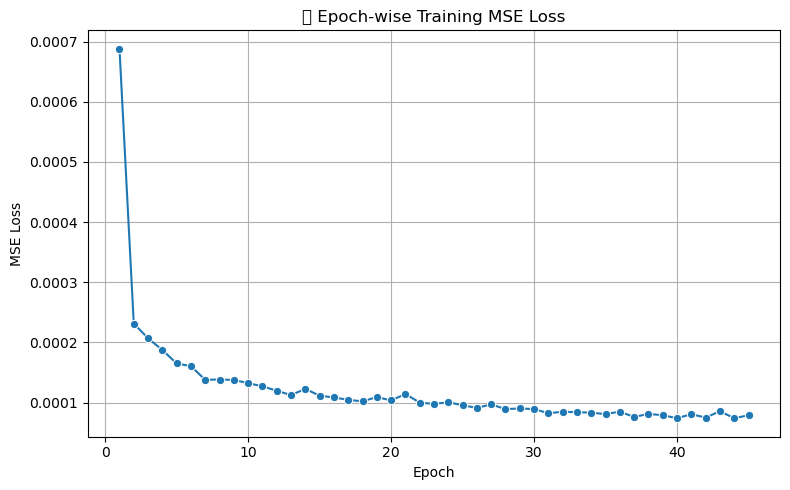

C:\Users\absaa\AppData\Local\Temp\ipykernel_23432\3976296943.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\absaa\AppData\Local\Temp\ipykernel_23432\3976296943.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "loss_deltas.png"))
c:\Users\absaa\anaconda3\envs\torch-gpu-copy\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


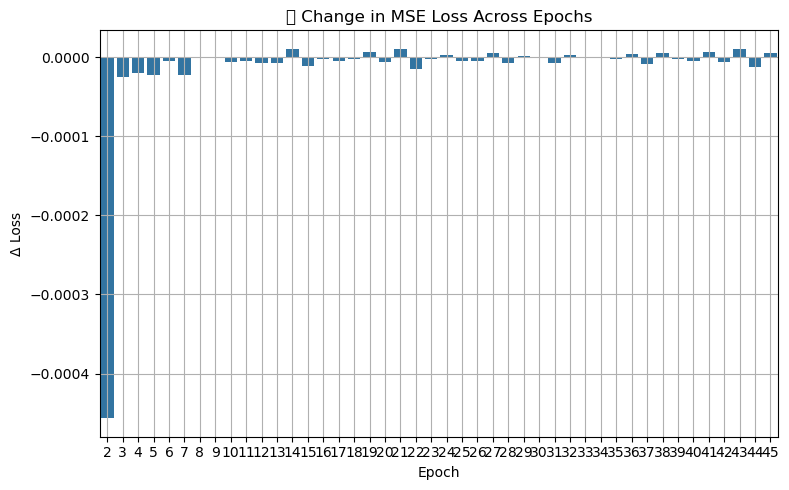

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

def plot_training_analysis(epoch_losses, output_dir="../outputs/analysis"):
    os.makedirs(output_dir, exist_ok=True)

    # Save epoch loss log to disk
    loss_log_path = os.path.join(output_dir, "epoch_losses.json")
    with open(loss_log_path, "w") as f:
        json.dump(epoch_losses, f)
    print(f"📄 Saved epoch loss log to: {loss_log_path}")

    # Plot raw loss curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=list(range(1, len(epoch_losses)+1)), y=epoch_losses, marker="o")
    plt.title("📉 Epoch-wise Training MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_curve.png"))
    plt.show()

    # Plot loss changes
    loss_deltas = [epoch_losses[i] - epoch_losses[i-1] for i in range(1, len(epoch_losses))]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(range(2, len(epoch_losses)+1)), y=loss_deltas)
    plt.title("📊 Change in MSE Loss Across Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Δ Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_deltas.png"))
    plt.show()

# Example usage (paste this after training):
plot_training_analysis(loss_log)


In [11]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Load full car IDs from training split
with open("../data/subset_dir/train_design_ids.txt") as f:
    all_ids = [line.strip() for line in f]

# Select 100 unseen IDs after first 1000 used in training
test_ids = all_ids[5000:5300]

# Load CSV for ground truth Cd values
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

preds = []
trues = []

for car_id in test_ids:
    path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    data = np.load(path)

    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        cd_pred = model(slices, point_mask, slice_mask).item()

    cd_true = df[df["Design"] == car_id]["Average Cd"].values[0]

    preds.append(cd_pred)
    trues.append(cd_true)

    print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.4f} | True Cd: {cd_true:.4f}")

# Compute and print R²
r2 = r2_score(trues, preds)
print(f"\n📊 R² Score on unseen 100-car subset: {r2:.4f}")


🚗 DrivAer_F_D_WM_WW_3697 → Predicted Cd: 0.3013 | True Cd: 0.3203
🚗 DrivAer_F_D_WM_WW_1540 → Predicted Cd: 0.2830 | True Cd: 0.2775
🚗 DrivAer_F_D_WM_WW_3894 → Predicted Cd: 0.2803 | True Cd: 0.3005
🚗 DrivAer_F_D_WM_WW_1310 → Predicted Cd: 0.2790 | True Cd: 0.2976
🚗 DrivAer_F_D_WM_WW_3822 → Predicted Cd: 0.2823 | True Cd: 0.2898
🚗 DrivAer_F_D_WM_WW_2872 → Predicted Cd: 0.3002 | True Cd: 0.3109
🚗 DrivAer_F_D_WM_WW_1616 → Predicted Cd: 0.2961 | True Cd: 0.3060
🚗 DrivAer_F_D_WM_WW_0163 → Predicted Cd: 0.2823 | True Cd: 0.2822
🚗 DrivAer_F_D_WM_WW_1719 → Predicted Cd: 0.3144 | True Cd: 0.3341
🚗 DrivAer_F_D_WM_WW_0964 → Predicted Cd: 0.2807 | True Cd: 0.2713
🚗 DrivAer_F_D_WM_WW_3265 → Predicted Cd: 0.3142 | True Cd: 0.3349
🚗 DrivAer_F_D_WM_WW_2894 → Predicted Cd: 0.3072 | True Cd: 0.3281
🚗 DrivAer_F_D_WM_WW_3882 → Predicted Cd: 0.2838 | True Cd: 0.2852
🚗 DrivAer_F_D_WM_WW_0885 → Predicted Cd: 0.3119 | True Cd: 0.3253
🚗 DrivAer_F_D_WM_WW_1937 → Predicted Cd: 0.2828 | True Cd: 0.2820
🚗 DrivAer_

In [12]:
# -----------------------------
# 🔍 Robust Evaluation Script for complete Validation/Test Sets
# -----------------------------
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# CHANGE THIS to 'val_design_ids.txt' or 'test_design_ids.txt'
id_file = "../data/subset_dir/val_design_ids.txt"

# Load car IDs from val/test set
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd CSV
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Storage
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        cd_pred = model(slices, point_mask, slice_mask).item()

    cd_true = df[df["Design"] == car_id]["Average Cd"].values[0]

    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final Metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
os.makedirs("../outputs/eval", exist_ok=True)
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")


🚗 E_S_WW_WM_107 → Predicted Cd: 0.280019 | True Cd: 0.291263
🚗 F_S_WWS_WM_219 → Predicted Cd: 0.280797 | True Cd: 0.282675
🚗 F_S_WWC_WM_402 → Predicted Cd: 0.234959 | True Cd: 0.255362
🚗 N_S_WW_WM_231 → Predicted Cd: 0.236858 | True Cd: 0.250860
🚗 N_S_WWS_WM_300 → Predicted Cd: 0.233305 | True Cd: 0.212679
🚗 E_S_WWC_WM_031 → Predicted Cd: 0.260273 | True Cd: 0.250199
🚗 N_S_WWS_WM_347 → Predicted Cd: 0.271350 | True Cd: 0.261281
🚗 E_S_WWC_WM_640 → Predicted Cd: 0.269852 | True Cd: 0.245123
🚗 N_S_WWS_WM_330 → Predicted Cd: 0.249199 | True Cd: 0.236111
🚗 E_S_WW_WM_203 → Predicted Cd: 0.286815 | True Cd: 0.292899
🚗 N_S_WWC_WM_191 → Predicted Cd: 0.238655 | True Cd: 0.244601
🚗 E_S_WWC_WM_641 → Predicted Cd: 0.282419 | True Cd: 0.274664
🚗 N_S_WWC_WM_087 → Predicted Cd: 0.256892 | True Cd: 0.249482
🚗 F_S_WWC_WM_666 → Predicted Cd: 0.261131 | True Cd: 0.276765
🚗 N_S_WWC_WM_219 → Predicted Cd: 0.272403 | True Cd: 0.290724
🚗 F_S_WWS_WM_248 → Predicted Cd: 0.238053 | True Cd: 0.249032
🚗 F_S_WWC_W